In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [10]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifex_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [13]:
lifex_df2 = lifex_df.copy()

print(lifex_df2.describe())

# check percentage of null values
lifex_df2.isnull().sum()*100/lifex_df2.isnull().count()

              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2928.000000      2928.000000    2938.000000   
mean   2007.518720         69.224932       164.796448      30.303948   
std       4.613841          9.523867       124.292079     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.100000        74.000000       0.000000   
50%    2008.000000         72.100000       144.000000       3.000000   
75%    2012.000000         75.700000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [14]:
## format the column names
lifex_df2.columns = lifex_df2.columns.str.strip()
lifex_df2.columns = lifex_df2.columns.str.upper()
lifex_df2.columns = lifex_df2.columns.str.replace(' ', '_')

In [15]:
#filling in missing values
columns = ["LIFE_EXPECTANCY", "ADULT_MORTALITY", "ALCOHOL", "HEPATITIS_B", "INFANT_DEATHS", 
           "MEASLES", "UNDER-FIVE_DEATHS", "HIV/AIDS",
           "BMI", "POLIO", "TOTAL_EXPENDITURE", "DIPHTHERIA", "GDP", "POPULATION", "PERCENTAGE_EXPENDITURE",
           "THINNESS__1-19_YEARS", "THINNESS_5-9_YEARS", "INCOME_COMPOSITION_OF_RESOURCES", "SCHOOLING"]

#interpolate missing values
for column in columns:
    lifex_df2.loc[:, column].fillna(lifex_df2.loc[:, column].interpolate(), inplace=True)
    
lifex_df2.dropna(inplace=True)

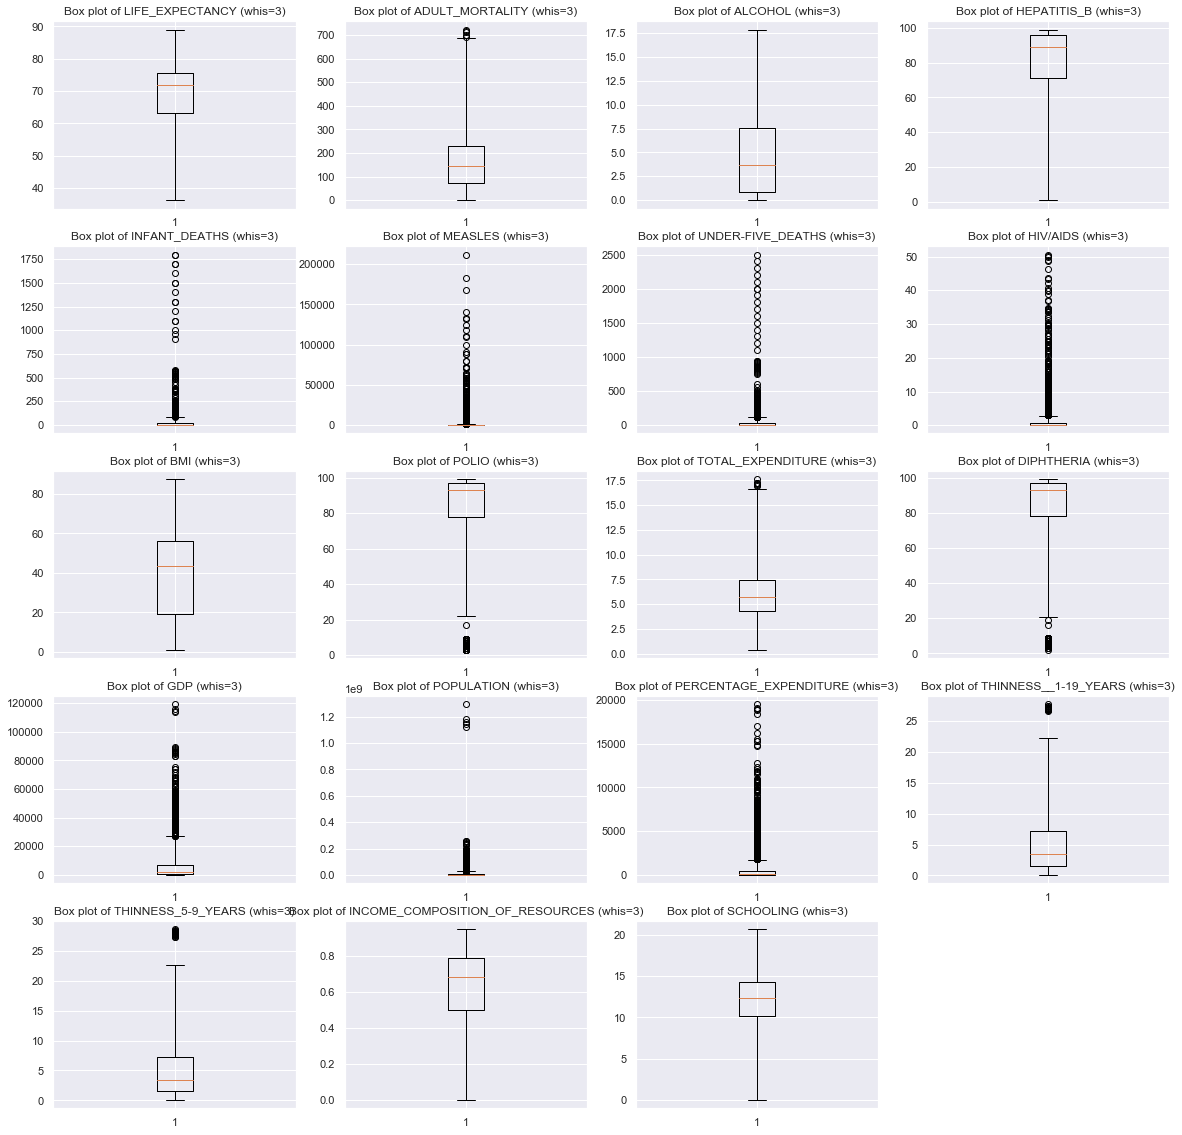

In [17]:
## check for outliers in boxplots

plt.figure(figsize = (20,20))

i = 1

for column in columns:
    plt.subplot(5,4,i)
    plt.boxplot(lifex_df2[column], whis=3)
    plt.title("Box plot of {} (whis=3)".format(column))
    i+=1
    
plt.show()

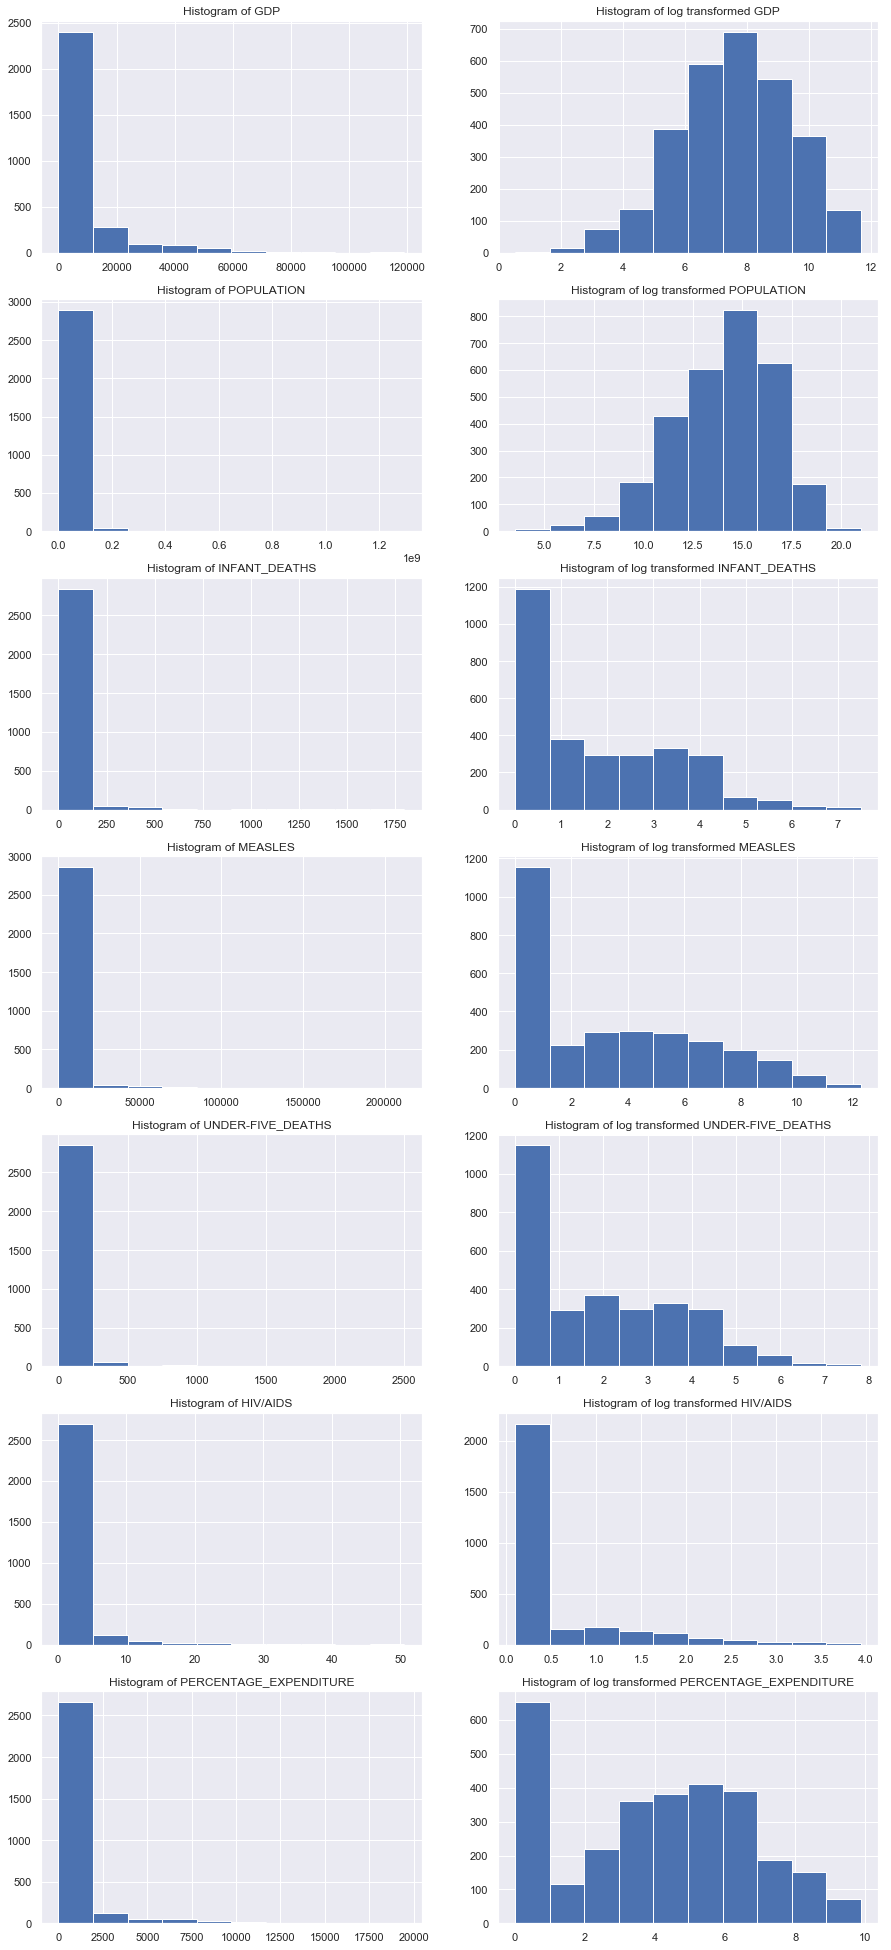

In [25]:
# check histograms of log transformation for GDP and POPULATION

plt.figure(figsize = (15,35))

constant = 1

plt.subplot(7,2,1)
plt.hist(lifex_df2["GDP"])
plt.title("Histogram of GDP")

plt.subplot(7,2,2)
plt.hist(np.log(lifex_df2["GDP"]))
plt.title("Histogram of log transformed GDP")

plt.subplot(7,2,3)
plt.hist(lifex_df2["POPULATION"])
plt.title("Histogram of POPULATION")

plt.subplot(7,2,4)
plt.hist(np.log(lifex_df2["POPULATION"]))
plt.title("Histogram of log transformed POPULATION")

plt.subplot(7,2,5)
plt.hist(lifex_df2["INFANT_DEATHS"])
plt.title("Histogram of INFANT_DEATHS")

plt.subplot(7,2,6)
plt.hist(np.log(lifex_df2["INFANT_DEATHS"] + constant))
plt.title("Histogram of log transformed INFANT_DEATHS")

plt.subplot(7,2,7)
plt.hist(lifex_df2["MEASLES"])
plt.title("Histogram of MEASLES")

plt.subplot(7,2,8)
plt.hist(np.log(lifex_df2["MEASLES"] + constant))
plt.title("Histogram of log transformed MEASLES")

plt.subplot(7,2,9)
plt.hist(lifex_df2["UNDER-FIVE_DEATHS"])
plt.title("Histogram of UNDER-FIVE_DEATHS")

plt.subplot(7,2,10)
plt.hist(np.log(lifex_df2["UNDER-FIVE_DEATHS"] + constant))
plt.title("Histogram of log transformed UNDER-FIVE_DEATHS")

plt.subplot(7,2,11)
plt.hist(lifex_df2["HIV/AIDS"])
plt.title("Histogram of HIV/AIDS")

plt.subplot(7,2,12)
plt.hist(np.log(lifex_df2["HIV/AIDS"] + constant))
plt.title("Histogram of log transformed HIV/AIDS")

plt.subplot(7,2,13)
plt.hist(lifex_df2["PERCENTAGE_EXPENDITURE"])
plt.title("Histogram of PERCENTAGE_EXPENDITURE")

plt.subplot(7,2,14)
plt.hist(np.log(lifex_df2["PERCENTAGE_EXPENDITURE"] + constant))
plt.title("Histogram of log transformed PERCENTAGE_EXPENDITURE")





plt.show()

Most of the above variables are good candidates for log transformation, although several of them are strongly skewed left.

In [26]:

#winsorize other variables with outliers or unexplained zeros
lifex_df2["ADULT_MORTALITY"] = winsorize(lifex_df2["ADULT_MORTALITY"], (0.05, 0.05))
lifex_df2["POLIO"] = winsorize(lifex_df2["POLIO"], (0.1, 0))
lifex_df2["TOTAL_EXPENDITURE"] = winsorize(lifex_df2["TOTAL_EXPENDITURE"], (0.05, 0.05))
lifex_df2["DIPHTHERIA"] = winsorize(lifex_df2["DIPHTHERIA"], (0.1, 0))
lifex_df2["THINNESS__1-19_YEARS"] = winsorize(lifex_df2["THINNESS__1-19_YEARS"], (0.05, 0.05))
lifex_df2["THINNESS_5-9_YEARS"] = winsorize(lifex_df2["THINNESS_5-9_YEARS"], (0.05, 0.05))
lifex_df2["INFANT_DEATHS"] = winsorize(lifex_df2["INFANT_DEATHS"], (0.05, 0))
lifex_df2["MEASLES"] = winsorize(lifex_df2["MEASLES"], (0.05, 0))
lifex_df2["UNDER-FIVE_DEATHS"] = winsorize(lifex_df2["UNDER-FIVE_DEATHS"], (0.05, 0))
lifex_df2["HIV/AIDS"] = winsorize(lifex_df2["HIV/AIDS"], (0.05, 0))
lifex_df2["PERCENTAGE_EXPENDITURE"] = winsorize(lifex_df2["PERCENTAGE_EXPENDITURE"], (0.05, 0))

lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"] = winsorize(lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"], (0.05, 0))
lifex_df2["SCHOOLING"] = winsorize(lifex_df2["SCHOOLING"], (0.05, 0))
lifex_df2["HEPATITIS_B"] = winsorize(lifex_df2["HEPATITIS_B"], (0.05, 0))
lifex_df2["ALCOHOL"] = winsorize(lifex_df2["ALCOHOL"], (0.05, 0))


#log transform
lifex_df2["GDP"] = (np.log(lifex_df2["GDP"]))
lifex_df2["POPULATION"] = (np.log(lifex_df2["POPULATION"]))

lifex_df2["INFANT_DEATHS"] = (np.log(lifex_df2["INFANT_DEATHS"]))
lifex_df2["MEASLES"] = (np.log(lifex_df2["MEASLES"]))
lifex_df2["UNDER-FIVE_DEATHS"] = (np.log(lifex_df2["UNDER-FIVE_DEATHS"]))
lifex_df2["HIV/AIDS"] = (np.log(lifex_df2["HIV/AIDS"]))
lifex_df2["PERCENTAGE_EXPENDITURE"] = (np.log(lifex_df2["PERCENTAGE_EXPENDITURE"]))


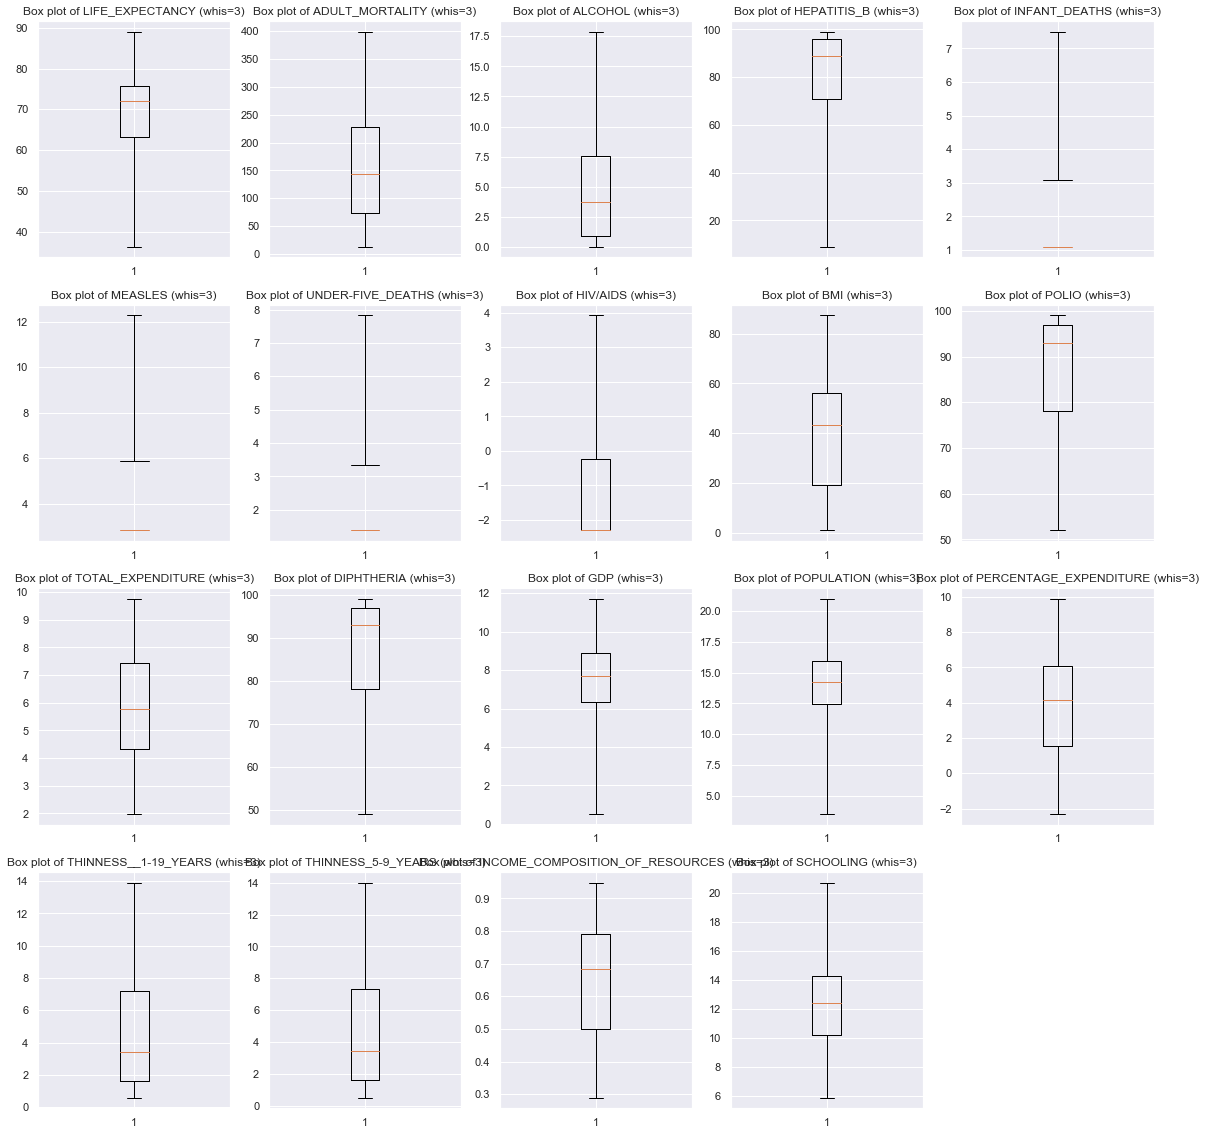

In [27]:
## check again for outliers in boxplots

plt.figure(figsize = (20,20))

i = 1

for column in columns:
    plt.subplot(4,5,i)
    plt.boxplot(lifex_df2[column], whis=3)
    plt.title("Box plot of {} (whis=3)".format(column))
    i+=1
    
plt.show()

The outliers have been removed.

In [28]:
#check for correlation among variables

lifex_df2.corr()

,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,MEASLES,BMI,UNDER-FIVE_DEATHS,POLIO,TOTAL_EXPENDITURE,DIPHTHERIA,HIV/AIDS,GDP,POPULATION,THINNESS__1-19_YEARS,THINNESS_5-9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING
YEAR,1.000000,0.168309,-0.060533,-0.032082,-0.064487,0.159427,0.146437,-0.136869,0.100417,-0.046995,0.118496,0.071884,0.148799,-0.095239,0.131011,0.030462,-0.039277,-0.038794,0.193774,0.175776
LIFE_EXPECTANCY,0.168309,1.000000,-0.682404,-0.502150,0.400068,0.597009,0.248495,-0.315395,0.556433,-0.554894,0.569382,0.230461,0.569790,-0.811782,0.535982,-0.055706,-0.533158,-0.533117,0.783010,0.729098
ADULT_MORTALITY,-0.060533,-0.682404,1.000000,0.302958,-0.209123,-0.375116,-0.166914,0.185222,-0.398473,0.341284,-0.360758,-0.149195,-0.356705,0.609426,-0.339752,0.056116,0.365952,0.376068,-0.521812,-0.469786
INFANT_DEATHS,-0.032082,-0.502150,0.302958,1.000000,-0.321529,-0.416698,-0.248690,0.515835,-0.445165,0.995225,-0.401563,-0.205964,-0.393746,0.312575,-0.344040,0.299880,0.425364,0.434956,-0.455324,-0.466175
ALCOHOL,-0.064487,0.400068,-0.209123,-0.321529,1.000000,0.450275,0.092298,-0.215792,0.319618,-0.349643,0.272984,0.315399,0.269493,-0.195155,0.412042,-0.001384,-0.446380,-0.436866,0.502771,0.532417
PERCENTAGE_EXPENDITURE,0.159427,0.597009,-0.375116,-0.416698,0.450275,1.000000,0.113223,-0.265790,0.441916,-0.443276,0.353179,0.245413,0.346975,-0.388415,0.942057,-0.010610,-0.417790,-0.432952,0.648370,0.628429
HEPATITIS_B,0.146437,0.248495,-0.166914,-0.248690,0.092298,0.113223,1.000000,-0.223005,0.173127,-0.271337,0.501282,0.103414,0.556717,-0.234865,0.124885,-0.017265,-0.131023,-0.139227,0.218073,0.211110
MEASLES,-0.136869,-0.315395,0.185222,0.515835,-0.215792,-0.265790,-0.223005,1.000000,-0.332033,0.527494,-0.336603,-0.188251,-0.332146,0.207949,-0.217884,0.185331,0.315885,0.321086,-0.271272,-0.320116
BMI,0.100417,0.556433,-0.398473,-0.445165,0.319618,0.441916,0.173127,-0.332033,1.000000,-0.477343,0.341747,0.236043,0.337156,-0.483680,0.389098,-0.034499,-0.559187,-0.568374,0.528126,0.517848
UNDER-FIVE_DEATHS,-0.046995,-0.554894,0.341284,0.995225,-0.349643,-0.443276,-0.271337,0.527494,-0.477343,1.000000,-0.441268,-0.201371,-0.434836,0.371735,-0.374553,0.298863,0.445906,0.453536,-0.509251,-0.512678


INCOME_COMPOSITION_OF_RESOURCES and SCHOOLING are the two variables most highly positively correlated with LIFE_EXPECTANCY, and HIV/AIDS shows the strongest correlation, although it is negative.

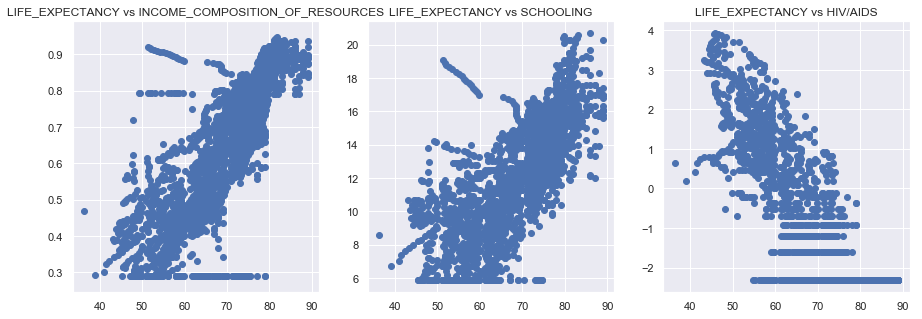

In [29]:
#generate scatter plots

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(lifex_df2["LIFE_EXPECTANCY"], lifex_df2["INCOME_COMPOSITION_OF_RESOURCES"])
plt.title("LIFE_EXPECTANCY vs INCOME_COMPOSITION_OF_RESOURCES")

plt.subplot(1,3,2)
plt.scatter(lifex_df2["LIFE_EXPECTANCY"], lifex_df2["SCHOOLING"])
plt.title("LIFE_EXPECTANCY vs SCHOOLING")

plt.subplot(1,3,3)
plt.scatter(lifex_df2["LIFE_EXPECTANCY"], lifex_df2["HIV/AIDS"])
plt.title("LIFE_EXPECTANCY vs HIV/AIDS")

plt.show()

The strong correlations of the INCOME_COMPOSITION_OF_RESOURCES and SCHOOLING variables with LIFE_EXPECTANCY suggests that they would be ideal for use in the modeling phase.  Several of the variables have moderate correlation (~ +/- 0.5), and could be good candiates for PCA.  These include ALCOHOL, PERCENTAGE_EXPENDITURE, BMI, POLIO, DIPTHERIA, HIV/AIDS, GDP, and both THINNESS variables.  